# SVD

## Import libraries

In [1]:
from lib.models import RecommendSystemModel

from typing import List, Any, Tuple,Union
from numpy.typing import NDArray
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

# import tensorflow as tf
np.random.seed(3362)
import sys
print(sys.version)
print(sys.version_info)
import time

3.7.13 (default, Oct 18 2022, 13:40:53) 
[Clang 12.0.0 ]
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)


## Function to update class in Jupyter Notebook 
https://stackoverflow.com/questions/45161393/jupyter-split-classes-in-multiple-cells

In [2]:
import functools
def update_class(
    main_class=None, exclude=("__module__", "__name__", "__dict__", "__weakref__")
):
    """Class decorator. Adds all methods and members from the wrapped class to main_class

    Args:
    - main_class: class to which to append members. Defaults to the class with the same name as the wrapped class
    - exclude: black-list of members which should not be copied
    """

    def decorates(main_class, exclude, appended_class):
        if main_class is None:
            main_class = globals()[appended_class.__name__]
        for k, v in appended_class.__dict__.items():
            if k not in exclude:
                setattr(main_class, k, v)
        return main_class

    return functools.partial(decorates, main_class, exclude)

### Example

In [3]:
class MyClass:
    def method1(self):
        print("method1")
me = MyClass()


In [4]:
@update_class()
class MyClass:
    def method2(self):
        print("method2")
me.method1()
me.method2()

method1
method2


## The ML model

In [5]:
class SVDModel(RecommendSystemModel):
    def __init__(
        self,
        mode: str = None,
        features: int = None,
        lr: float = None,
        epochs: int = None,
        weight_decay: float = None,
        stopping: float = None,
        momentum: float = None,
    ) -> None:
        super().__init__()
        # Data frame
        self.data: pd.DataFrame
        # # Training data
        self.train: NDArray
        # # Validating Data
        self.valid: NDArray
        self.test: NDArray
        # SVD mode
        self.mode: str = mode or "funk"
        # Number of features
        self.features: int = features or 5
        # Learning rate
        self.lr: float = lr or 0.01
        # Number of total epochs
        self.epochs: int = epochs or 101
        # the weight decay
        self.weight_decay: float = weight_decay or 0.02
        self.stopping: float = stopping or 0.001
        self.momentum: float = momentum or 0.0
        # Tensor SGD optimizer
        # self.optimizer = tf.keras.optimizers.SGD(learning_rate=self.lr, momentum=self.momentum,)

        # User latent matrix
        self._P: NDArray  # = np.random.rand(self.n_users, features) * 0.1
        # Item latent matrix
        self._Q: NDArray  # = np.random.rand(self.n_items, features) * 0.1



In [6]:
@update_class()
class SVDModel(RecommendSystemModel):
    def split(
        self, ratio_train_test: float, ratio_train_valid: float, tensor: bool = False
    ) -> None:
        userItemMatrix = (
            self.data[["userId", "movieId", "rating"]]
            .pivot_table(columns="movieId", index="userId", values="rating")
            .fillna(0)
        )

        for label in range(1, self.n_items):
            if label not in userItemMatrix.columns:
                userItemMatrix[label] = 0
        userItemMatrix = userItemMatrix[sorted(userItemMatrix.columns)].to_numpy()
        print(f"User Item Matrix Shape: {userItemMatrix.shape}")
        print(f"User Reference length: {self.n_users}")
        print(f"Item Reference length: {self.n_items}")

        n = len(userItemMatrix)
        m = len(userItemMatrix[0])

        trainBeforeSplit = userItemMatrix.copy()
        trainBeforeSplit.fill(0)
        self.train = trainBeforeSplit.copy()
        self.valid = trainBeforeSplit.copy()
        self.test = trainBeforeSplit.copy()

        for i in range(n):
            for j in range(m):
                if userItemMatrix[i, j]:
                    if np.random.binomial(1, ratio_train_test, 1):
                        if np.random.binomial(1, ratio_train_valid, 1):
                            self.train[i, j] = userItemMatrix[i, j]
                        else:
                            self.valid[i, j] = userItemMatrix[i, j]
                    else:
                        self.test[i, j] = userItemMatrix[i, j]

In [7]:
@update_class()
class SVDModel(RecommendSystemModel):
    def data_loader(
        self,
        path: str = None,
        nrows: int = None,
        skiprows=None,
        data: pd.DataFrame = None,
        n_users: int = None,
        n_items=None,
    ) -> None:
        if not path and data.empty:
            raise "Error: one of path or data frame should be provided"
        if data.empty:
            self.data = pd.read_csv(
                path, low_memory=False, nrows=nrows, skiprows=skiprows
            )
        elif not path:
            self.data = data

        # create reference of users and movies
        self.users_ref = self.data["userId"].unique()
        self.users_ref.sort()
        self.movies_ref = self.data["movieId"].unique()
        self.movies_ref.sort()

        self.n_users = len(self.users_ref)
        self.n_items = n_items

In [8]:

@update_class()
class SVDModel(RecommendSystemModel):
    def _process(self,id_user,id_item):
        predict = self.prediction(id_user, id_item)
        error = self.train[id_user, id_item] - predict
#         errors.append(error)
        self.optimize(error, id_user, id_item)
        return error
            
    def _run(self,id_user, id_item):
        self._process(id_user,id_item)
        
    def _train_one_epoches(self):
        return [self._run(id_user, id_item) for id_user in range(self.n_users) for id_item in range(self.n_items) if self.train[id_user, id_item] > 0]

    def training(self) -> Tuple[NDArray, NDArray, float, float]:
        loss_train = []
        loss_valid = []
        errors = []

        self._P = np.random.rand(self.n_users, self.features) * 0.1
        self._Q = np.random.rand(self.n_items, self.features) * 0.1

        # for advanced SVD
        self._bu = np.zeros(self.n_users)
        self._bi = np.zeros(self.n_items)
        self.mean = 0  # TODO calculate the mean of rating

        # Johnny
        for e in range(self.epochs):
            tic = time.perf_counter()
            
            _errors = self._train_one_epoches()
            errors += _errors
            
            trainLoss = self.loss(self.train)
            validLoss = self.loss(self.valid)
            loss_train.append(trainLoss)
            loss_valid.append(validLoss)
            
            if e % 10 == 0:
                print(
                    "Epoch : ",
                    "{:3.0f}".format(e + 1),
                    " | Train :",
                    "{:3.3f}".format(trainLoss),
                    " | Valid :",
                    "{:3.3f}".format(validLoss),
                    " | Time :", "{:3.5f}".format(time.perf_counter()-tic)
                )
                tic = time.perf_counter()

            if e > 1:
                if abs(validLoss - trainLoss) < self.stopping:
                    break
        print("Training stopped:")
        print(
            "Epoch : ",
            "{:3.0f}".format(e + 1),
            " | Train :",
            "{:3.3f}".format(trainLoss),
            " | Valid :",
            "{:3.3f}".format(validLoss),
            " | Time :", "{:3.5f}".format(time.perf_counter()-tic)
        )
        return loss_train, loss_valid, errors
    # , errors'''


In [9]:
@update_class()
class SVDModel(RecommendSystemModel):
    def prediction(self, u: int, i: int) -> float:
        # Woody
        # print(P[u: ])
        predict = np.dot(self._P[u, : ], self._Q[i, : ])
        if self.mode == 'svd++':
            predict += self._mean + self._bu[u] + self._bi[i]
        return predict

In [10]:
@update_class()
class SVDModel(RecommendSystemModel):
    def loss(self, groundTruthData) -> float:
        # Woody
        squaredErrors = 0.0
        numOfPrediction = 0
        for u in range(self.n_users):
            for i in range(self.n_items):
                if groundTruthData[u, i] > 0:
                    squaredErrors += pow(
                        groundTruthData[u, i] - self.prediction(u, i), 2
                    )
                    numOfPrediction += 1
        return squaredErrors / numOfPrediction

In [11]:
@update_class()
class SVDModel(RecommendSystemModel):
    def optimize(self, error: float, id_user: int, id_item: int):
        # Johnny
        self._P[id_user, :] += self.lr * (
            error * self._Q[id_item, :] - self.weight_decay * self._P[id_user, :]
        )
        self._Q[id_item, :] += self.lr * (
            error * self._P[id_user, :] - self.weight_decay * self._Q[id_item, :]
        )


# Try with an example

In [12]:
# define the paths
data_path = './data/ml-latest-small/'
df_rating = pd.read_csv(data_path+'ratings.csv')
df_movies = pd.read_csv(data_path+'movies.csv')
m_movies = df_movies['movieId'].nunique()
n_users = df_rating['userId'].nunique()
n_ratings = len(df_rating)

In [13]:
print(m_movies)
print(n_users)
print(df_rating)
print(df_movies)

9742
610
        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]
      movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  B

In [14]:
df_movies['movieId'].max()

193609

In [15]:
df_rating['userId'].max()

610

In [16]:
df_movies.insert(1, 'newMovieId', value=range(1,len(df_movies)+1))

In [17]:
newMovieIdDict = {}
for index, movie in df_movies.iterrows():
  newMovieIdDict[movie['movieId']] = movie['newMovieId']

In [18]:
newMovieIdDict[193583]

9739

In [19]:
df_rating.replace({"movieId": newMovieIdDict}, inplace=True)

In [20]:
# for index, rating in df_rating.iterrows():
#   if index % 100000 == 0: print('{}/{}'.format(index, len(df_rating)))
#   rating['movieId'] = newMovieIdDict[rating['movieId']]

In [21]:
# for index, movie in df_movies.iterrows():
#   for index, rating in df_rating.iterrows():
#     if rating['movieId'] == movie['movieId']:
#       rating['movieId'] = index+1

In [22]:
# for index, movie in df_movies.iterrows():
#   c = df_rating['movieId'].eq(movie['movieId'])
#   df_rating.loc[c,'movieId']=index+1

In [23]:
# data = np.array(df_rating,dtype=int)
# u3 = data[:, 1][data[:, 0] == 3]
# print(len(u3))
# print(u3)

In [24]:
df_rating['rating'] = df_rating['rating'].astype(np.int64)
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   userId     100836 non-null  int64
 1   movieId    100836 non-null  int64
 2   rating     100836 non-null  int64
 3   timestamp  100836 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [25]:
df_rating.empty

False

In [26]:
features = 1
lr = 0.01
epochs = 11
weight_decay = 0.02
stopping = 0.001

svd = SVDModel(features=features, lr=lr, epochs=epochs, weight_decay=weight_decay, stopping=stopping)

In [27]:
svd.data_loader(data=df_rating, n_items = m_movies, n_users=n_users)

In [28]:
# print(svd.n_items)
# print(svd.__dict__)
# svd.n_items = 10

In [29]:
svd.split(0.6,0.8)

User Item Matrix Shape: (610, 9742)
User Reference length: 610
Item Reference length: 9742


In [30]:
print(len(svd.test), len(svd.test[0]))

610 9742


In [31]:
'''
Epoch :    1  | Train : 9.425  | Valid : 9.630
Epoch :   11  | Train : 0.738  | Valid : 1.485
Training stopped:
Epoch :   11  | Train : 0.738  | Valid : 1.485
95.74433708299999s
'''
tic = time.perf_counter()
loss_train, loss_valid,_ = svd.training()
toc = time.perf_counter()
print(f'{toc-tic}s')
# , errors 

Epoch :    1  | Train : 9.425  | Valid : 9.630  | Time : 9.38286
Epoch :   11  | Train : 0.738  | Valid : 1.485  | Time : 8.57082
Training stopped:
Epoch :   11  | Train : 0.738  | Valid : 1.485  | Time : 0.00002
97.8602595s


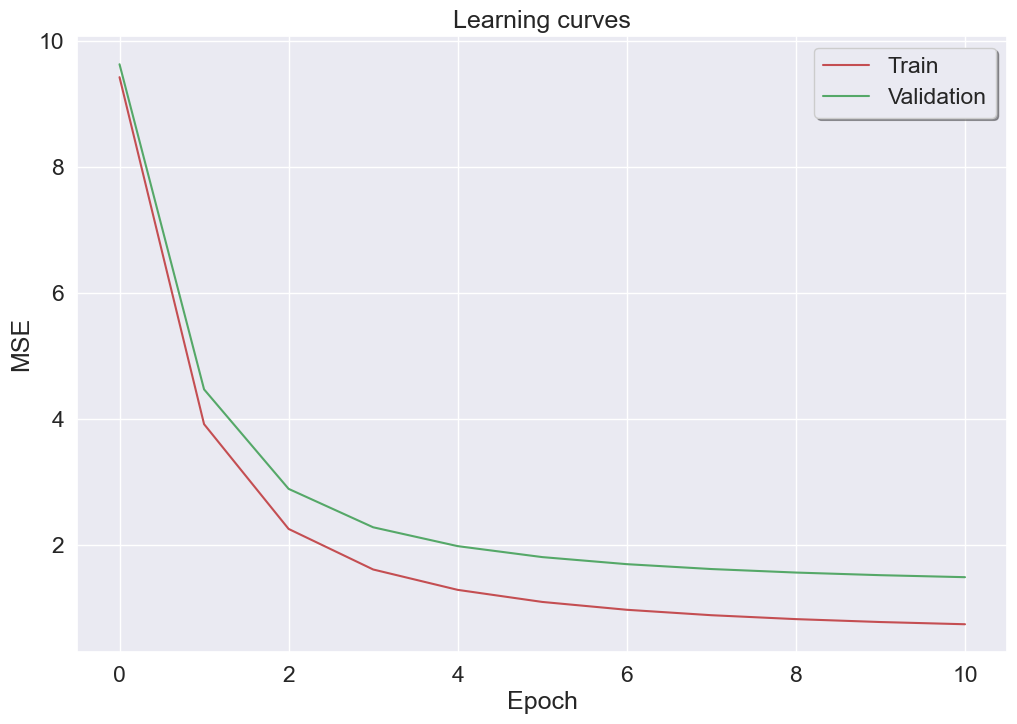

In [32]:
x = list(range(len(loss_train)))
k=0

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)

plt.plot(x[-k:], loss_train[-k:], 'r', label="Train")
plt.plot(x[-k:], loss_valid[-k:], 'g', label="Validation")
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
leg = plt.legend(loc='best', shadow=True, fancybox=True)